In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

- https://www.youtube.com/watch?v=ElmBrKyMXxs
- https://github.com/hans/ipython-notebooks/blob/master/tf/TF%20tutorial.ipynb
- https://github.com/ematvey/tensorflow-seq2seq-tutorials

In [2]:
from __future__ import division
import tensorflow as tf
from os import path, remove
import numpy as np
import pandas as pd
import csv
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
from mylibs.jupyter_notebook_helper import show_graph, renderStatsList, renderStatsCollection, \
    renderStatsListWithLabels, renderStatsCollectionOfCrossValids
from tensorflow.contrib import rnn
from tensorflow.contrib import learn
import shutil
from tensorflow.contrib.learn.python.learn import learn_runner
from mylibs.tf_helper import getDefaultGPUconfig
from sklearn.metrics import r2_score
from mylibs.py_helper import factors
from fastdtw import fastdtw
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from common import get_or_run_nn
from data_providers.price_history_seq2seq_data_provider import PriceHistorySeq2SeqDataProvider
from data_providers.price_history_dataset_generator import PriceHistoryDatasetGenerator
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from models.price_history_20_seq2seq_raw_L2reg import PriceHistorySeq2SeqRawL2reg

/home/studenthp/anaconda2/envs/dis/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
dtype = tf.float32
seed = 16011984
random_state = np.random.RandomState(seed=seed)
config = getDefaultGPUconfig()
n_jobs = 1
%matplotlib inline

### Step 0 - hyperparams

vocab_size is all the potential words you could have (classification for translation case)
and max sequence length are the SAME thing

decoder RNN hidden units are usually same size as encoder RNN hidden units in translation but for our case it does not seem really to be a relationship there but we can experiment and find out later, not a priority thing right now

In [4]:
epochs = 10

num_features = 1
num_units = 400 #state size

input_len = 60
target_len = 30
lamda2 = 1e-2

batch_size = 50 #47
#trunc_backprop_len = ??
with_EOS = False

In [5]:
total_train_size = 57994
train_size = 6400 
test_size = 1282

### Once generate data

In [6]:
data_path = '../data/price_history'

In [7]:
#npz_full_train = data_path + '/price_history_03_dp_60to30_train.npz'
#npz_full_train = data_path + '/price_history_60to30_targets_normed_train.npz'

#npz_train = data_path + '/price_history_03_dp_60to30_57980_train.npz'
#npz_train = data_path + '/price_history_03_dp_60to30_6400_train.npz'
npz_train = data_path + '/price_history_60to30_6400_targets_normed_train.npz'

#npz_test = data_path + '/price_history_03_dp_60to30_test.npz'
npz_test = data_path + '/price_history_60to30_targets_normed_test.npz'

### Step 1 - collect data

In [8]:
dp = PriceHistorySeq2SeqDataProvider(npz_path=npz_train, batch_size=batch_size, with_EOS=with_EOS)
dp.inputs.shape, dp.targets.shape

((6400, 60, 1), (6400, 30))

In [9]:
aa, bb = dp.next()
aa.shape, bb.shape

((50, 60, 1), (50, 30))

### Step 2 - Build model

In [10]:
model = PriceHistorySeq2SeqRawL2reg(rng=random_state, dtype=dtype, config=config, with_EOS=with_EOS)

In [11]:
graph = model.getGraph(batch_size=batch_size,
                       num_units=num_units,
                       input_len=input_len,
                       target_len=target_len,
                       lamda2=lamda2)

60
Tensor("inputs/unstack:0", shape=(50, 1), dtype=float32)

Tensor("encoder_rnn_layer/rnn/gru_cell_59/add:0", shape=(50, 400), dtype=float32)

time
Tensor("decoder_rnn_layer/rnn/while/add:0", shape=(), dtype=int32)

decoder_final_loop_state
Tensor("decoder_rnn_layer/rnn/while/Exit_5:0", shape=(50, 30), dtype=float32)


Tensor("error/Select:0", shape=(50, 30), dtype=float32)

Tensor("error/Mean:0", shape=(), dtype=float32)
Tensor("error/Mean:0", shape=(), dtype=float32)



In [12]:
#show_graph(graph)

### Step 3 training the network

RECALL: baseline is around 4 for huber loss for current problem, anything above 4 should be considered as major errors

In [13]:
#rnn_cell = PriceHistorySeq2SeqCV.RNN_CELLS.GRU
#cross_val_n_splits = 5
epochs, num_units, batch_size

(10, 400, 50)

In [14]:
#set(factors(train_size)).intersection(factors(train_size/5))

In [15]:
best_learning_rate = 1e-3 #0.0026945952539362472
keep_prob_input = 0.7

In [17]:
def experiment():
    return model.run(npz_path=npz_train,
             epochs=epochs,
             batch_size = batch_size,
             num_units = num_units,
             input_len=input_len,
             target_len=target_len,
             learning_rate = best_learning_rate,
             preds_gather_enabled=True,
             keep_prob_input = keep_prob_input,
             lamda2=lamda2,
            )

Recall that without batch normalization within 10 epochs with num units 400 and batch_size 64 we reached at 4.940
and with having the decoder inputs NOT filled from the outputs

In [18]:
%%time
dyn_stats, preds_dict = get_or_run_nn(
  experiment,
  filename='020_seq2seq_60to30_epochs{}_learning_rate_{:.4f}_prob_input{}_lamda2_{}'.format(
      epochs, best_learning_rate, keep_prob_input, lamda2
  ))

epochs: 10
learning_rate: 0.001
keep_prob_input: 0.7
End Epoch 01 (33.989 secs): err(train) = 1.885
End Epoch 02 (31.163 secs): err(train) = 1.234
End Epoch 03 (31.200 secs): err(train) = 1.137
End Epoch 04 (31.174 secs): err(train) = 1.096
End Epoch 05 (31.178 secs): err(train) = 1.067
End Epoch 06 (31.171 secs): err(train) = 1.050
End Epoch 07 (31.153 secs): err(train) = 1.044
End Epoch 08 (31.160 secs): err(train) = 1.035
End Epoch 09 (31.132 secs): err(train) = 1.022
End Epoch 10 (31.165 secs): err(train) = 1.021

CPU times: user 5min 41s, sys: 24.3 s, total: 6min 6s
Wall time: 5min 37s


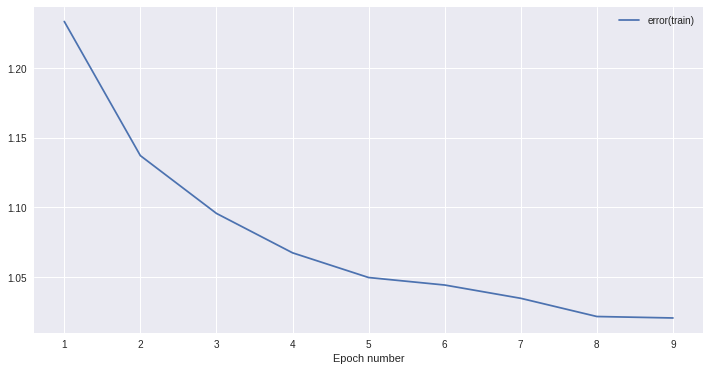

In [19]:
dyn_stats.plotStats()
plt.show()

In [20]:
r2_scores = [r2_score(y_true=dp.targets[ind], y_pred=preds_dict[ind])
            for ind in range(len(dp.targets))]

In [21]:
ind = np.argmin(r2_scores)
ind

4398

In [22]:
reals = dp.targets[ind]
preds = preds_dict[ind]

In [23]:
r2_score(y_true=reals, y_pred=preds)

-2.7592718626733534e+29

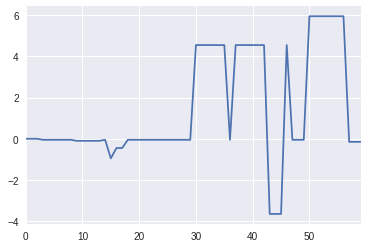

In [24]:
sns.tsplot(data=dp.inputs[ind].flatten())

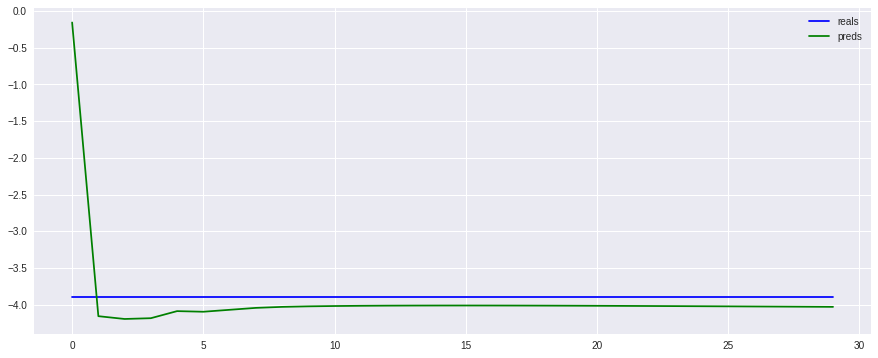

In [25]:
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

In [26]:
%%time
dtw_scores = [fastdtw(dp.targets[ind], preds_dict[ind])[0]
             for ind in range(len(dp.targets))]

CPU times: user 14.4 s, sys: 148 ms, total: 14.6 s
Wall time: 14.4 s


In [27]:
np.mean(dtw_scores)

10.159119268465412

In [28]:
coint(preds, reals)

(-0.16109172841461997,
 0.98136900142336125,
 array([-4.31395736, -3.55493606, -3.19393252]))

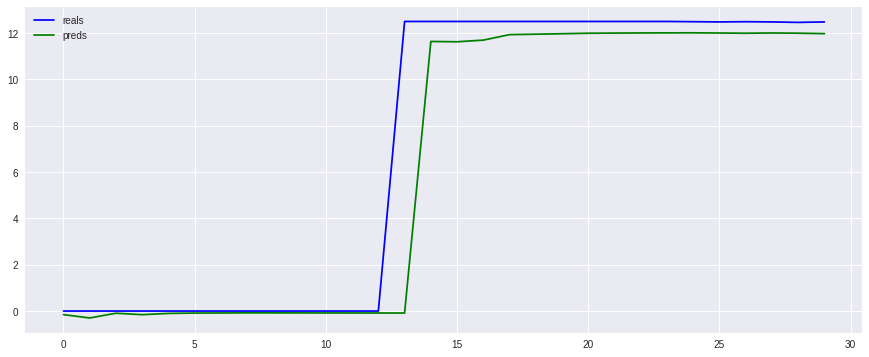

In [38]:
cur_ind = np.random.randint(len(dp.targets))
reals = dp.targets[cur_ind]
preds = preds_dict[cur_ind]
fig = plt.figure(figsize=(15,6))
plt.plot(reals, 'b')
plt.plot(preds, 'g')
plt.legend(['reals','preds'])
plt.show()

#### Conclusion
???